In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from logger import logger
import pandas as pd
from common_functions import NPCL, common
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

npcl_obj = NPCL()
common_obj  = common()

### data ingestion

In [2]:
df = npcl_obj.data_ingestion_npcl(data_path=os.getenv("data_path"))
data = npcl_obj.data_cleaning_and_validation(df)
# common_obj.correlation_matrix(df=data)

data.set_index(['creation_time'],drop= True, inplace= True)
resample_df = data[['Load_kW']].resample(rule="h").mean()

### features additions (lags, timeseries, weather, holidays)

from_date:  2024-07-01 to_date:  2024-07-31


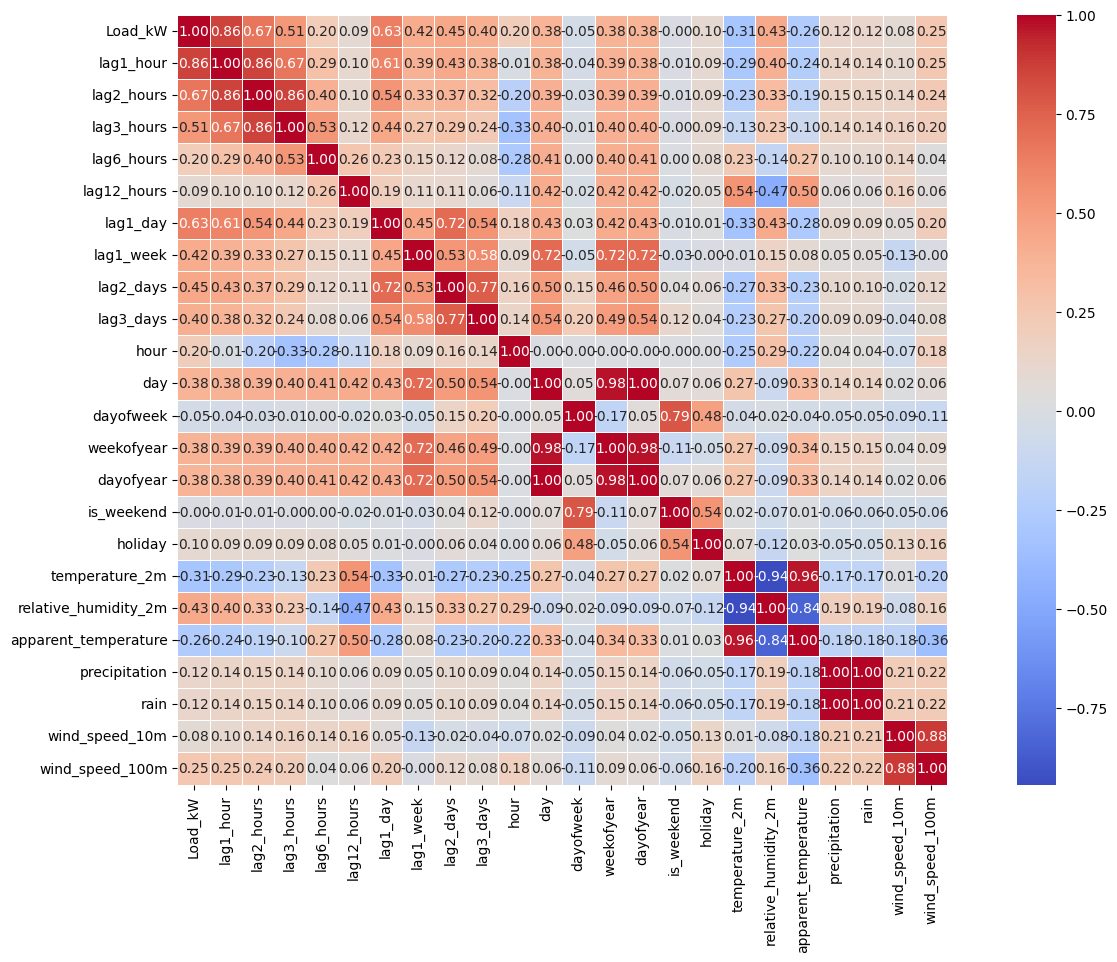

In [3]:

latitude, longitude = "28.625361","77.376214" #, 28.628059,77.378912

from_date = resample_df.first_valid_index().date()
to_date = resample_df.last_valid_index().date()
print("from_date: ",from_date,"to_date: ",to_date)
weather_df = npcl_obj.weather_data_api(latitude,longitude,from_date,to_date)
holidays_lst= common_obj.holidays_list(from_date,to_date)
# print("holidays_lst:",holidays_lst)

df_lags = common_obj.add_lags(resample_df,target_col="Load_kW")
df2 = common_obj.create_features(df_lags)
for date in holidays_lst:
    df2.loc[f"{date}", 'holiday'] = 1
df2.fillna(0,inplace= True)
df3 = df2.merge(weather_df,on=["creation_time"])
# df3.drop(['creation_time'],axis=1,inplace=True)
common_obj.correlation_matrix(df3)

# pca
pca_df ,pca_result = common_obj.pca_function(df3)
# common_obj.pca_plot(pca_result)


### data split and training

# with all features


Model Power Evaluation
Mean Squared Error (MSE): 0.0018008388308976154
Mean Absolute Error (MAE): 0.03286906581852951
R-squared: 0.898313660243596


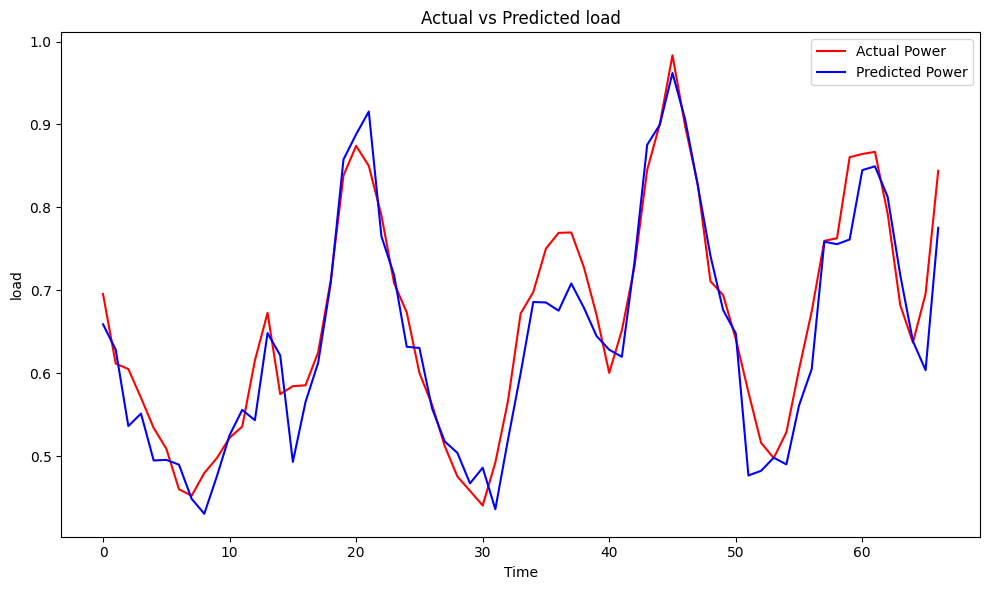


Model Power Evaluation
Mean Squared Error (MSE): 0.026838117092322533
Mean Absolute Error (MAE): 0.13389317418556337
R-squared: 0.4410815067791545


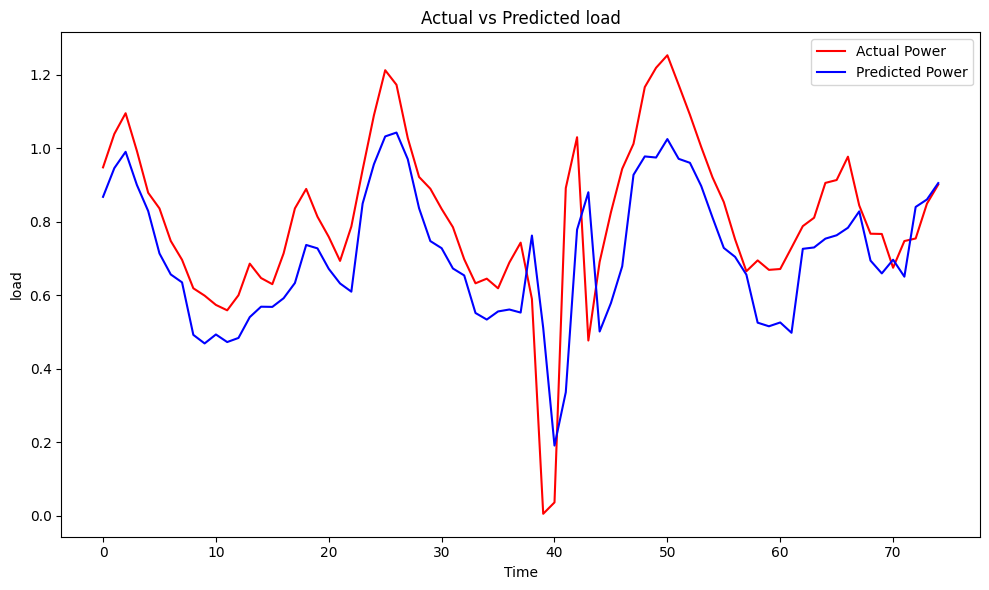

In [4]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3, target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)



### removing features on basis of correlation

In [ ]:
df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours', 'lag1_day',  'lag2_days', 'hour', 'day', 'dayofweek','is_weekend', 'relative_humidity_2m', 'rain','wind_speed_10m']]


Model Power Evaluation
Mean Squared Error (MSE): 0.0023396335882215624
Mean Absolute Error (MAE): 0.0370565061722052
R-squared: 0.8678900233182953


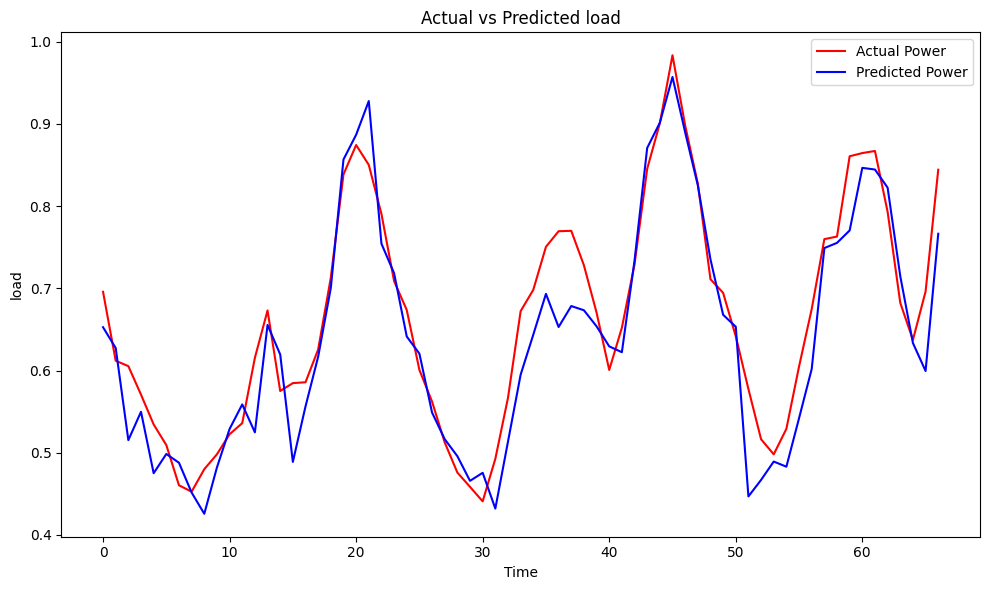


Model Power Evaluation
Mean Squared Error (MSE): 0.025846620951584586
Mean Absolute Error (MAE): 0.13072518692735124
R-squared: 0.4617299571569965


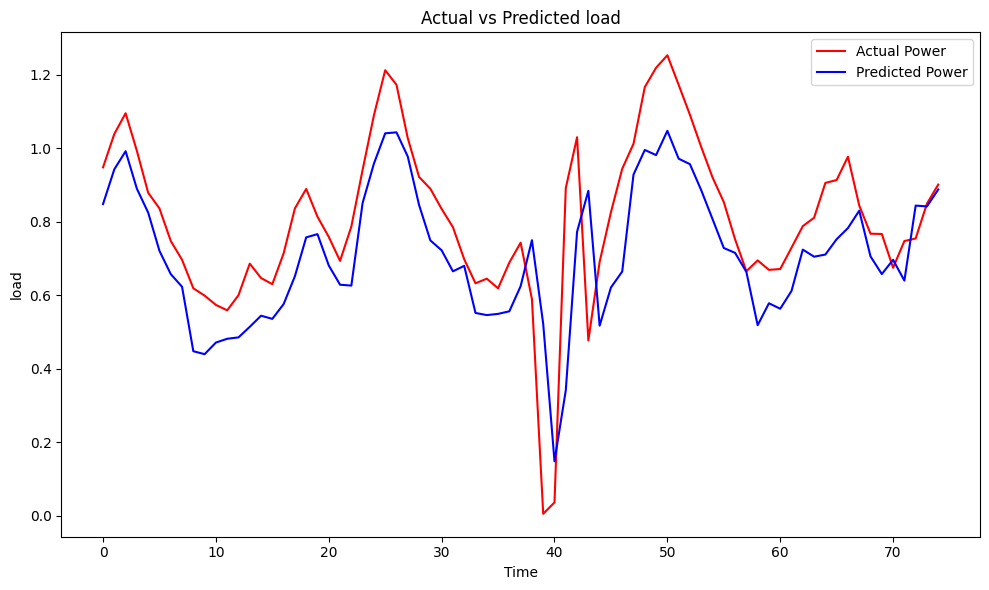

In [5]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours', 'lag1_day',  'lag2_days', 'hour', 'day', 'dayofweek','is_weekend', 'relative_humidity_2m', 'rain','wind_speed_10m']], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)



In [6]:
['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag2_days', 'lag3_days',
       'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend',
       'holiday', 'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'rain', 'wind_speed_10m',
       'wind_speed_100m']

Index(['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag2_days', 'lag3_days',
       'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend',
       'holiday', 'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'rain', 'wind_speed_10m',
       'wind_speed_100m'],
      dtype='object')

### without weather data


Model Power Evaluation
Mean Squared Error (MSE): 0.0024744984675106486
Mean Absolute Error (MAE): 0.037160881893582715
R-squared: 0.860274729988708


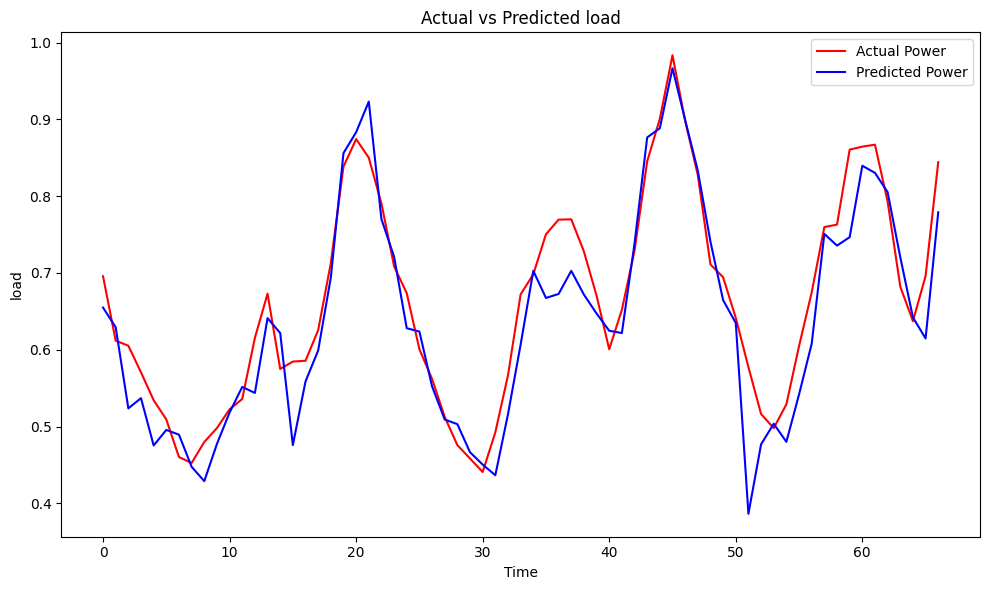


Model Power Evaluation
Mean Squared Error (MSE): 0.02471784581294776
Mean Absolute Error (MAE): 0.12638239064574636
R-squared: 0.48523731788210944


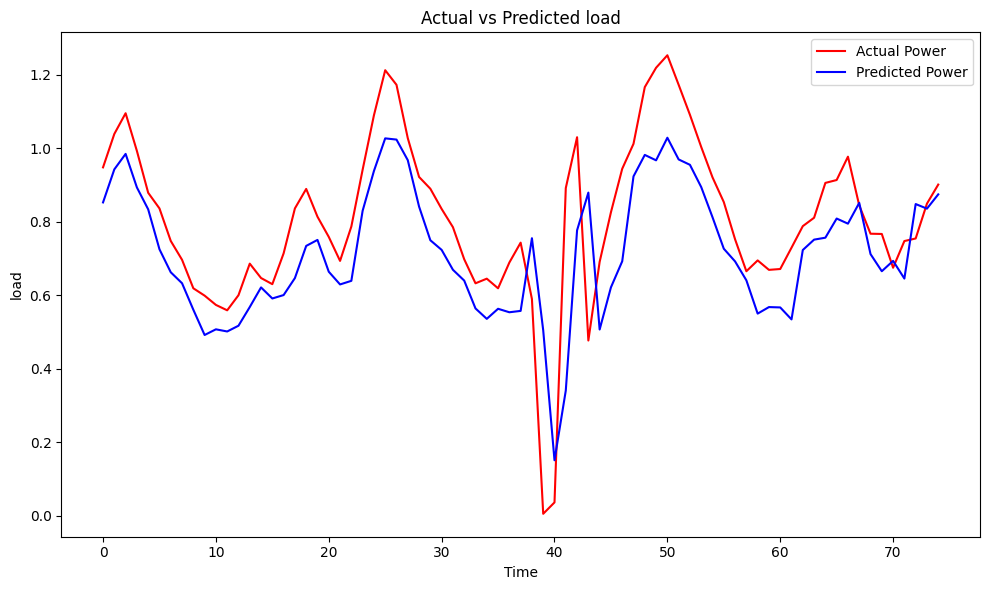

In [7]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag2_days', 'lag3_days',
       'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend']
], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)



### lags and weather both


Model Power Evaluation
Mean Squared Error (MSE): 0.0030256639372329528
Mean Absolute Error (MAE): 0.04083123952209969
R-squared: 0.8291525672195698


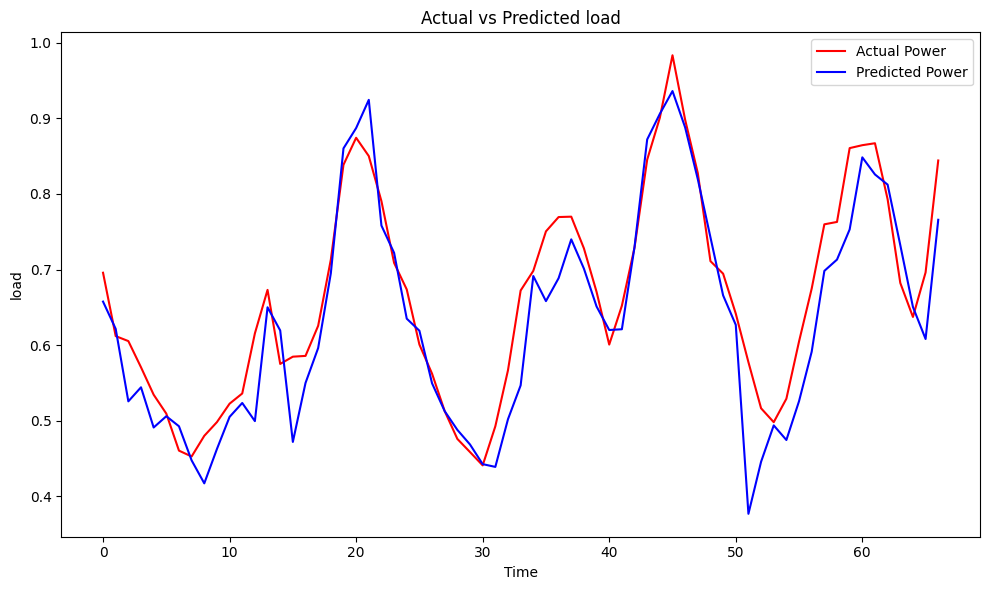


Model Power Evaluation
Mean Squared Error (MSE): 0.024179712048322158
Mean Absolute Error (MAE): 0.1269465851671275
R-squared: 0.4964442483773134


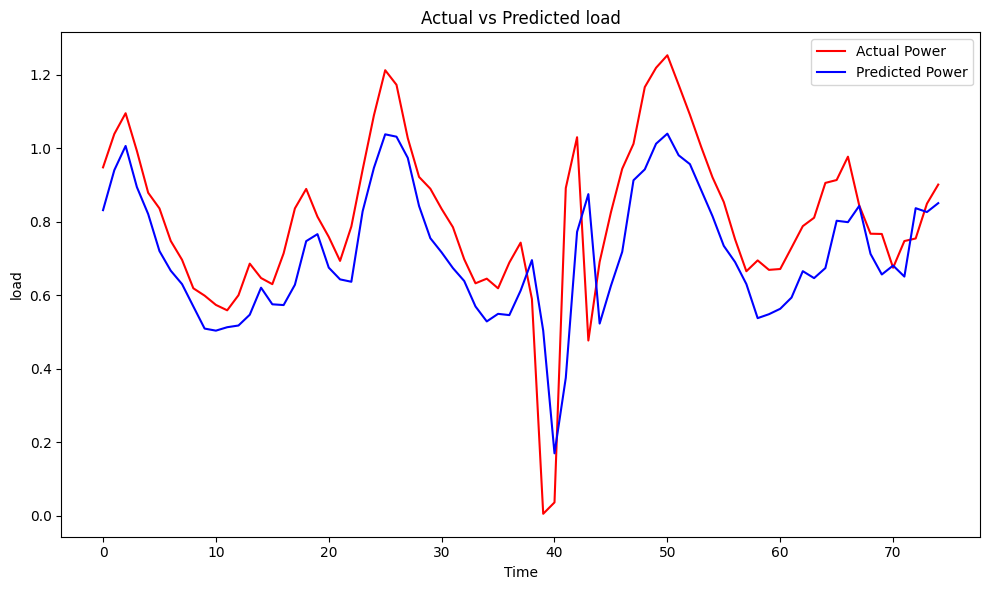

In [8]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 
        'lag1_day','lag3_days',
       'hour', 'day', 'dayofweek', 'dayofyear', 'is_weekend']
], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)



In [9]:
df3.columns

Index(['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours', 'lag6_hours',
       'lag12_hours', 'lag1_day', 'lag1_week', 'lag2_days', 'lag3_days',
       'hour', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend',
       'holiday', 'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'rain', 'wind_speed_10m',
       'wind_speed_100m'],
      dtype='object')


Model Power Evaluation
Mean Squared Error (MSE): 0.002187878545068549
Mean Absolute Error (MAE): 0.03510811139939865
R-squared: 0.8764590382756824


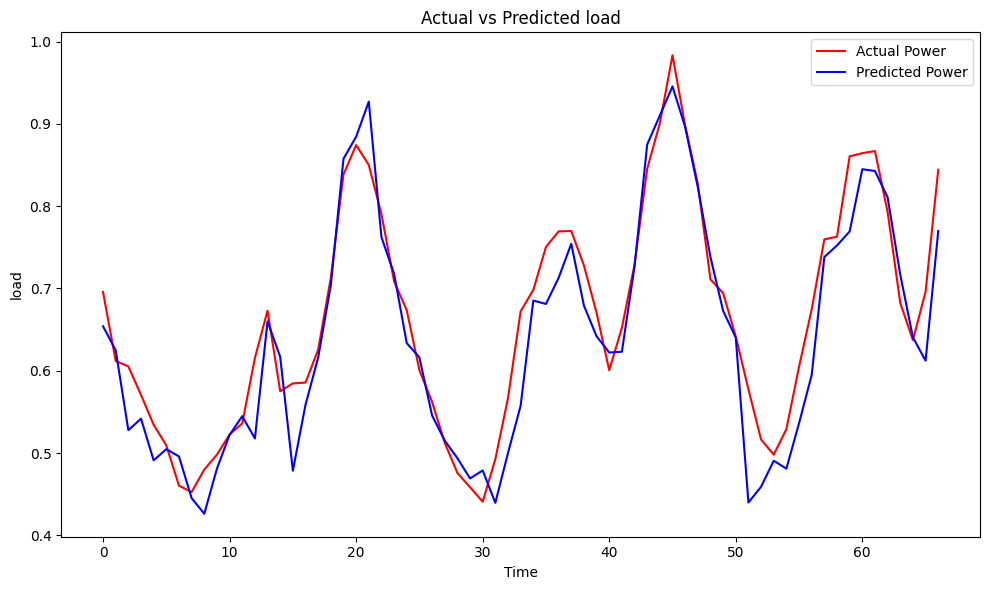


Model Power Evaluation
Mean Squared Error (MSE): 0.025292996873489664
Mean Absolute Error (MAE): 0.13118528086758885
R-squared: 0.47325948191743916


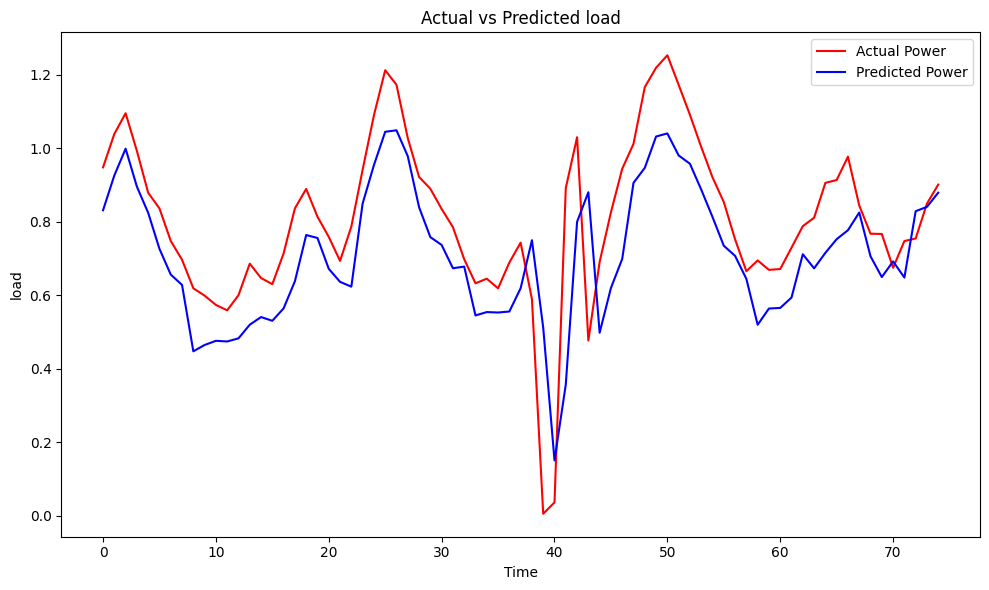

In [10]:

X_train, X_test, y_train, y_test = common_obj.data_split_function(df3[['Load_kW', 'lag1_hour', 'lag2_hours', 'lag3_hours','lag1_day','lag3_days','hour', 'day', 'dayofweek', 'dayofyear', 'is_weekend','temperature_2m', 'rain', 'wind_speed_10m']], target_variable= "Load_kW")
X_train = common_obj.scaling_layer(X_train)
model= common_obj.model_trainer(X_train,y_train,model_name="RFR")
pred = common_obj.prediction(model,X_test,scoring=True,test_data=y_test,prediction=True)

